# 56. 小規模データでのPivot戦略有効性検証

## 背景

実験55（40万件Wikipedia）での結論:
- Pivot t=20: 削減率47.2%, Recall@10 89.8% ◎
- Pivot t=15: 削減率73.9%, Recall@10 85.3% ○
- Overlap (8,4): 削減率88.0%, Recall@10 84.5% △

非公開データ（2,789件）での結果:
- Overlap (8,4): 削減率45-56%, Recall 79-80%
- Pivot t=15: 削減率18-27%, Recall 78-83%
- Pivot t=20: 削減率3-5%, Recall 85-87%

→ **小規模データでは削減率が大幅に低下**

## 目的

公開データ（Wikipedia）を間引いて5,000件〜10,000件で検証:
1. データ規模と削減率の関係を明確化
2. ピボット戦略が有効なデータ規模の閾値を特定
3. 実験55の結論の妥当性を検証

## 0. セットアップ

In [2]:
import numpy as np
import time
from pathlib import Path
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import sys
sys.path.insert(0, '../src')
from itq_lsh import ITQLSH, hamming_distance_batch

DATA_DIR = Path("../data")
np.random.seed(42)

In [3]:
# データロード（40万件全体）
print("Loading full data...")
embeddings_full = np.load(DATA_DIR / "wikipedia_400k_e5_base_embeddings.npy")
hashes_full = np.load(DATA_DIR / "wikipedia_400k_e5_base_hashes_128bits.npy")
pivots = np.load(DATA_DIR / "pivots_8_furthest_first.npy")

print(f"Full data: {embeddings_full.shape[0]:,} documents")
print(f"Pivots: {pivots.shape}")

Loading full data...
Full data: 399,029 documents
Pivots: (8, 128)


## 1. ヘルパー関数定義

In [4]:
def hamming_distance(h1, h2):
    return np.sum(h1 != h2)

def hash_to_overlap_segments(hash_array, segment_width=8, stride=4):
    """オーバーラップセグメントを生成"""
    if hash_array.ndim == 1:
        hash_array = hash_array.reshape(1, -1)
    n_docs, n_bits = hash_array.shape
    n_segments = (n_bits - segment_width) // stride + 1
    
    segments = []
    for i in range(n_segments):
        start = i * stride
        end = start + segment_width
        segment_bits = hash_array[:, start:end]
        powers = 2 ** np.arange(segment_width - 1, -1, -1)
        segment_int = np.sum(segment_bits * powers, axis=1)
        segments.append(segment_int)
    
    return np.column_stack(segments), n_segments

def build_overlap_index(segments):
    """オーバーラップセグメントのインデックスを構築"""
    n_docs, n_segments = segments.shape
    index = {i: defaultdict(list) for i in range(n_segments)}
    
    for doc_idx in range(n_docs):
        for seg_idx in range(n_segments):
            seg_value = int(segments[doc_idx, seg_idx])
            index[seg_idx][seg_value].append(doc_idx)
    
    return index

def overlap_filter(query_segments, segment_index, n_segments):
    """Overlapフィルタ"""
    candidates = set()
    for seg_idx in range(n_segments):
        seg_value = int(query_segments[seg_idx])
        if seg_value in segment_index[seg_idx]:
            candidates.update(segment_index[seg_idx][seg_value])
    return np.array(list(candidates))

def pivot_filter(query_hash, pivots, all_pivot_distances, threshold):
    """ピボットフィルタリング"""
    n_docs, n_pivots = all_pivot_distances.shape
    query_pivot_dists = np.array([hamming_distance(query_hash, p) for p in pivots])
    
    mask = np.ones(n_docs, dtype=bool)
    for i in range(n_pivots):
        lower = query_pivot_dists[i] - threshold
        upper = query_pivot_dists[i] + threshold
        mask &= (all_pivot_distances[:, i] >= lower) & (all_pivot_distances[:, i] <= upper)
    
    return np.where(mask)[0]

def compute_ground_truth(query_embedding, all_embeddings, top_k=10):
    cosines = all_embeddings @ query_embedding
    top_indices = np.argsort(cosines)[-top_k:][::-1]
    return top_indices

def evaluate_recall(predicted, ground_truth, k):
    gt_set = set(ground_truth[:k])
    pred_set = set(predicted[:k]) if len(predicted) >= k else set(predicted)
    return len(gt_set & pred_set) / k

## 2. データ規模別の評価関数

In [5]:
def evaluate_at_scale(
    n_docs: int,
    embeddings_full: np.ndarray,
    hashes_full: np.ndarray,
    pivots: np.ndarray,
    n_queries: int = 100,
    top_k: int = 10,
    candidate_limit: int = 500,
    seed: int = 42
):
    """
    指定されたデータ規模で各戦略を評価
    """
    rng = np.random.default_rng(seed)
    
    # データサンプリング
    sample_indices = rng.choice(len(embeddings_full), n_docs, replace=False)
    embeddings = embeddings_full[sample_indices]
    hashes = hashes_full[sample_indices]
    
    print(f"\n{'='*70}")
    print(f"Evaluating at {n_docs:,} documents")
    print(f"{'='*70}")
    
    # ピボット距離を計算
    print("Computing pivot distances...")
    n_pivots = len(pivots)
    pivot_distances = np.zeros((n_docs, n_pivots), dtype=np.int16)
    for i in range(n_docs):
        for j in range(n_pivots):
            pivot_distances[i, j] = hamming_distance(hashes[i], pivots[j])
    
    # Overlapセグメント構築
    print("Building overlap index...")
    segments, n_segments = hash_to_overlap_segments(hashes, segment_width=8, stride=4)
    segment_index = build_overlap_index(segments)
    
    # クエリ準備
    query_indices = rng.choice(n_docs, n_queries, replace=False)
    
    # Ground Truth計算
    print("Computing ground truth...")
    ground_truths = {}
    for qi in query_indices:
        ground_truths[qi] = compute_ground_truth(embeddings[qi], embeddings, top_k)
    
    # 評価する戦略
    strategies = [
        ('Overlap (8,4)', lambda q_idx: overlap_filter(segments[q_idx], segment_index, n_segments)),
        ('Pivot t=10', lambda q_idx: pivot_filter(hashes[q_idx], pivots, pivot_distances, 10)),
        ('Pivot t=12', lambda q_idx: pivot_filter(hashes[q_idx], pivots, pivot_distances, 12)),
        ('Pivot t=15', lambda q_idx: pivot_filter(hashes[q_idx], pivots, pivot_distances, 15)),
        ('Pivot t=18', lambda q_idx: pivot_filter(hashes[q_idx], pivots, pivot_distances, 18)),
        ('Pivot t=20', lambda q_idx: pivot_filter(hashes[q_idx], pivots, pivot_distances, 20)),
        ('Pivot t=25', lambda q_idx: pivot_filter(hashes[q_idx], pivots, pivot_distances, 25)),
    ]
    
    results = []
    
    for name, filter_func in strategies:
        candidates_list = []
        filter_recall_list = []
        recall_list = []
        
        for q_idx in query_indices:
            # フィルタリング
            candidates = filter_func(q_idx)
            candidates = candidates[candidates != q_idx]
            candidates_list.append(len(candidates))
            
            # Filter Recall
            gt = ground_truths[q_idx]
            gt_in_candidates = sum(1 for g in gt[:top_k] if g in set(candidates)) / top_k
            filter_recall_list.append(gt_in_candidates)
            
            if len(candidates) == 0:
                recall_list.append(0.0)
                continue
            
            # ハミング距離でソート
            candidate_hashes = hashes[candidates]
            distances = hamming_distance_batch(hashes[q_idx], candidate_hashes)
            sorted_idx = np.argsort(distances)
            
            if len(sorted_idx) > candidate_limit:
                sorted_idx = sorted_idx[:candidate_limit]
            
            # コサイン類似度でリランク
            top_candidates = candidates[sorted_idx]
            candidate_embs = embeddings[top_candidates]
            cosines = candidate_embs @ embeddings[q_idx]
            final_order = np.argsort(cosines)[-top_k:][::-1]
            final_candidates = top_candidates[final_order]
            
            recall = evaluate_recall(final_candidates, gt, top_k)
            recall_list.append(recall)
        
        results.append({
            'n_docs': n_docs,
            'name': name,
            'candidates_mean': np.mean(candidates_list),
            'reduction_rate': 1 - np.mean(candidates_list) / n_docs,
            'filter_recall': np.mean(filter_recall_list),
            'recall@10': np.mean(recall_list),
        })
    
    return results

## 3. 複数データ規模での評価

In [6]:
# 評価するデータ規模
data_sizes = [3000, 5000, 10000, 20000, 50000, 100000]

all_results = []

for n_docs in data_sizes:
    results = evaluate_at_scale(
        n_docs=n_docs,
        embeddings_full=embeddings_full,
        hashes_full=hashes_full,
        pivots=pivots,
        n_queries=100,
        candidate_limit=500
    )
    all_results.extend(results)
    
    # 途中結果表示
    df_temp = pd.DataFrame(results)
    print(df_temp[['name', 'reduction_rate', 'filter_recall', 'recall@10']].to_string(index=False))


Evaluating at 3,000 documents
Computing pivot distances...
Building overlap index...
Computing ground truth...
         name  reduction_rate  filter_recall  recall@10
Overlap (8,4)        0.878933          0.630      0.630
   Pivot t=10        0.943670          0.383      0.383
   Pivot t=12        0.876193          0.574      0.574
   Pivot t=15        0.730850          0.773      0.772
   Pivot t=18        0.564223          0.857      0.853
   Pivot t=20        0.459810          0.886      0.879
   Pivot t=25        0.263007          0.898      0.887

Evaluating at 5,000 documents
Computing pivot distances...
Building overlap index...
Computing ground truth...
         name  reduction_rate  filter_recall  recall@10
Overlap (8,4)        0.875530          0.687      0.687
   Pivot t=10        0.945160          0.382      0.382
   Pivot t=12        0.880674          0.576      0.576
   Pivot t=15        0.739552          0.777      0.776
   Pivot t=18        0.575588          0.851    

In [7]:
# 全結果をDataFrameに
df_all = pd.DataFrame(all_results)
print("\n" + "="*100)
print("全結果サマリー")
print("="*100)
print(df_all.to_string(index=False))


全結果サマリー
 n_docs          name  candidates_mean  reduction_rate  filter_recall  recall@10
   3000 Overlap (8,4)           363.20        0.878933          0.630      0.630
   3000    Pivot t=10           168.99        0.943670          0.383      0.383
   3000    Pivot t=12           371.42        0.876193          0.574      0.574
   3000    Pivot t=15           807.45        0.730850          0.773      0.772
   3000    Pivot t=18          1307.33        0.564223          0.857      0.853
   3000    Pivot t=20          1620.57        0.459810          0.886      0.879
   3000    Pivot t=25          2210.98        0.263007          0.898      0.887
   5000 Overlap (8,4)           622.35        0.875530          0.687      0.687
   5000    Pivot t=10           274.20        0.945160          0.382      0.382
   5000    Pivot t=12           596.63        0.880674          0.576      0.576
   5000    Pivot t=15          1302.24        0.739552          0.777      0.776
   5000    Pivot t=

## 4. データ規模と削減率の関係を可視化

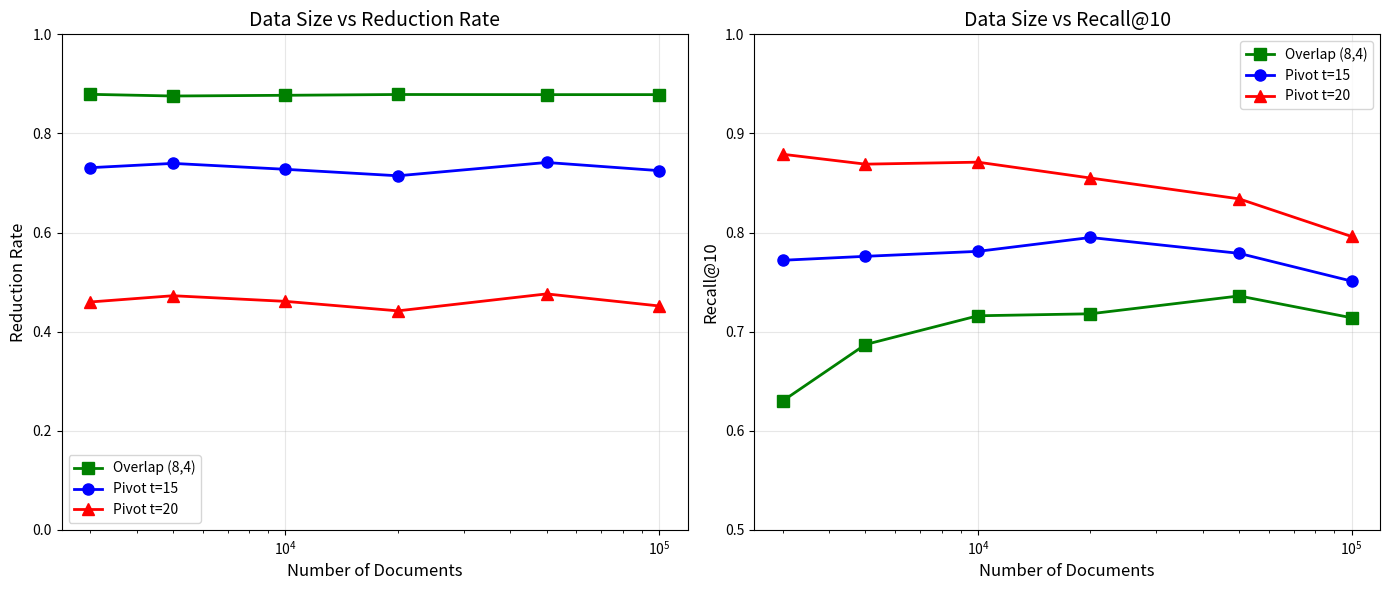

In [8]:
# 戦略別にデータ規模と削減率の関係をプロット
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

strategies_to_plot = ['Overlap (8,4)', 'Pivot t=15', 'Pivot t=20']
colors = {'Overlap (8,4)': 'green', 'Pivot t=15': 'blue', 'Pivot t=20': 'red'}
markers = {'Overlap (8,4)': 's', 'Pivot t=15': 'o', 'Pivot t=20': '^'}

# 削減率
ax1 = axes[0]
for strategy in strategies_to_plot:
    df_strategy = df_all[df_all['name'] == strategy]
    ax1.plot(df_strategy['n_docs'], df_strategy['reduction_rate'], 
             marker=markers[strategy], color=colors[strategy], 
             label=strategy, linewidth=2, markersize=8)

ax1.set_xlabel('Number of Documents', fontsize=12)
ax1.set_ylabel('Reduction Rate', fontsize=12)
ax1.set_title('Data Size vs Reduction Rate', fontsize=14)
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Recall@10
ax2 = axes[1]
for strategy in strategies_to_plot:
    df_strategy = df_all[df_all['name'] == strategy]
    ax2.plot(df_strategy['n_docs'], df_strategy['recall@10'], 
             marker=markers[strategy], color=colors[strategy], 
             label=strategy, linewidth=2, markersize=8)

ax2.set_xlabel('Number of Documents', fontsize=12)
ax2.set_ylabel('Recall@10', fontsize=12)
ax2.set_title('Data Size vs Recall@10', fontsize=14)
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.5, 1)

plt.tight_layout()
plt.savefig(DATA_DIR / '56_data_size_vs_performance.png', dpi=100, bbox_inches='tight')
plt.show()

## 5. 詳細比較表

In [9]:
# データ規模別のOverlap vs Pivot比較
print("\n" + "="*100)
print("データ規模別 Overlap vs Pivot 比較")
print("="*100)

for n_docs in data_sizes:
    df_size = df_all[df_all['n_docs'] == n_docs]
    
    overlap = df_size[df_size['name'] == 'Overlap (8,4)'].iloc[0]
    pivot15 = df_size[df_size['name'] == 'Pivot t=15'].iloc[0]
    pivot20 = df_size[df_size['name'] == 'Pivot t=20'].iloc[0]
    
    print(f"\n--- {n_docs:,}件 ---")
    print(f"{'戦略':<15} {'削減率':>10} {'Filter R':>10} {'Recall@10':>10}")
    print(f"{'-'*50}")
    print(f"{'Overlap (8,4)':<15} {overlap['reduction_rate']:>9.1%} {overlap['filter_recall']:>9.1%} {overlap['recall@10']:>9.1%}")
    print(f"{'Pivot t=15':<15} {pivot15['reduction_rate']:>9.1%} {pivot15['filter_recall']:>9.1%} {pivot15['recall@10']:>9.1%}")
    print(f"{'Pivot t=20':<15} {pivot20['reduction_rate']:>9.1%} {pivot20['filter_recall']:>9.1%} {pivot20['recall@10']:>9.1%}")


データ規模別 Overlap vs Pivot 比較

--- 3,000件 ---
戦略                     削減率   Filter R  Recall@10
--------------------------------------------------
Overlap (8,4)       87.9%     63.0%     63.0%
Pivot t=15          73.1%     77.3%     77.2%
Pivot t=20          46.0%     88.6%     87.9%

--- 5,000件 ---
戦略                     削減率   Filter R  Recall@10
--------------------------------------------------
Overlap (8,4)       87.6%     68.7%     68.7%
Pivot t=15          74.0%     77.7%     77.6%
Pivot t=20          47.2%     87.7%     86.9%

--- 10,000件 ---
戦略                     削減率   Filter R  Recall@10
--------------------------------------------------
Overlap (8,4)       87.7%     71.7%     71.6%
Pivot t=15          72.8%     78.8%     78.1%
Pivot t=20          46.1%     88.4%     87.1%

--- 20,000件 ---
戦略                     削減率   Filter R  Recall@10
--------------------------------------------------
Overlap (8,4)       87.9%     72.1%     71.8%
Pivot t=15          71.5%     81.3%     79.5%


In [10]:
# 削減率が50%を超えるデータ規模の閾値を特定
print("\n" + "="*80)
print("削減率50%を超えるデータ規模の閾値")
print("="*80)

for strategy in ['Overlap (8,4)', 'Pivot t=15', 'Pivot t=20']:
    df_strategy = df_all[df_all['name'] == strategy]
    above_50 = df_strategy[df_strategy['reduction_rate'] >= 0.5]
    if len(above_50) > 0:
        min_docs = above_50['n_docs'].min()
        print(f"{strategy}: {min_docs:,}件以上で削減率50%以上")
    else:
        print(f"{strategy}: 評価範囲内では削減率50%に達せず")


削減率50%を超えるデータ規模の閾値
Overlap (8,4): 3,000件以上で削減率50%以上
Pivot t=15: 3,000件以上で削減率50%以上
Pivot t=20: 評価範囲内では削減率50%に達せず


## 6. 40万件との比較

In [11]:
# 40万件全体での評価（実験55の結果を再現）
print("\n" + "="*70)
print("40万件全体での評価（参考）")
print("="*70)

# 既存のpivot_distancesを読み込む
pivot_distances_full = np.load(DATA_DIR / "wikipedia_400k_pivot_distances_8.npy")

# Overlapセグメント構築
print("Building overlap index for full data...")
segments_full, n_segments = hash_to_overlap_segments(hashes_full, segment_width=8, stride=4)
segment_index_full = build_overlap_index(segments_full)

# クエリ準備
rng = np.random.default_rng(42)
n_full = len(embeddings_full)
query_indices_full = rng.choice(n_full, 100, replace=False)

# Ground Truth
print("Computing ground truth...")
ground_truths_full = {}
for qi in tqdm(query_indices_full, desc="GT"):
    ground_truths_full[qi] = compute_ground_truth(embeddings_full[qi], embeddings_full, 10)

# 評価
strategies_full = [
    ('Overlap (8,4)', lambda q_idx: overlap_filter(segments_full[q_idx], segment_index_full, n_segments)),
    ('Pivot t=15', lambda q_idx: pivot_filter(hashes_full[q_idx], pivots, pivot_distances_full, 15)),
    ('Pivot t=20', lambda q_idx: pivot_filter(hashes_full[q_idx], pivots, pivot_distances_full, 20)),
]

results_full = []
for name, filter_func in strategies_full:
    candidates_list = []
    filter_recall_list = []
    recall_list = []
    
    for q_idx in query_indices_full:
        candidates = filter_func(q_idx)
        candidates = candidates[candidates != q_idx]
        candidates_list.append(len(candidates))
        
        gt = ground_truths_full[q_idx]
        gt_in_candidates = sum(1 for g in gt[:10] if g in set(candidates)) / 10
        filter_recall_list.append(gt_in_candidates)
        
        if len(candidates) == 0:
            recall_list.append(0.0)
            continue
        
        candidate_hashes = hashes_full[candidates]
        distances = hamming_distance_batch(hashes_full[q_idx], candidate_hashes)
        sorted_idx = np.argsort(distances)[:500]
        
        top_candidates = candidates[sorted_idx]
        candidate_embs = embeddings_full[top_candidates]
        cosines = candidate_embs @ embeddings_full[q_idx]
        final_order = np.argsort(cosines)[-10:][::-1]
        final_candidates = top_candidates[final_order]
        
        recall = evaluate_recall(final_candidates, gt, 10)
        recall_list.append(recall)
    
    results_full.append({
        'n_docs': n_full,
        'name': name,
        'candidates_mean': np.mean(candidates_list),
        'reduction_rate': 1 - np.mean(candidates_list) / n_full,
        'filter_recall': np.mean(filter_recall_list),
        'recall@10': np.mean(recall_list),
    })

df_full = pd.DataFrame(results_full)
print(df_full.to_string(index=False))


40万件全体での評価（参考）
Building overlap index for full data...
Computing ground truth...


GT: 100%|██████████| 100/100 [00:05<00:00, 18.76it/s]


 n_docs          name  candidates_mean  reduction_rate  filter_recall  recall@10
 399029 Overlap (8,4)         49278.84        0.876503          0.824      0.738
 399029    Pivot t=15        104080.33        0.739166          0.859      0.743
 399029    Pivot t=20        214848.44        0.461572          0.898      0.755


## 7. 結果サマリーと結論

In [12]:
# 全データ規模での比較表
print("\n" + "="*100)
print("全データ規模での比較サマリー")
print("="*100)

# 40万件の結果を追加
df_combined = pd.concat([df_all, df_full], ignore_index=True)

# ピボットテーブル形式で表示
for strategy in ['Overlap (8,4)', 'Pivot t=15', 'Pivot t=20']:
    df_s = df_combined[df_combined['name'] == strategy].sort_values('n_docs')
    print(f"\n--- {strategy} ---")
    print(f"{'データ件数':>12} {'削減率':>10} {'Filter R':>10} {'Recall@10':>10}")
    print("-"*50)
    for _, row in df_s.iterrows():
        print(f"{row['n_docs']:>12,} {row['reduction_rate']:>9.1%} {row['filter_recall']:>9.1%} {row['recall@10']:>9.1%}")


全データ規模での比較サマリー

--- Overlap (8,4) ---
       データ件数        削減率   Filter R  Recall@10
--------------------------------------------------
       3,000     87.9%     63.0%     63.0%
       5,000     87.6%     68.7%     68.7%
      10,000     87.7%     71.7%     71.6%
      20,000     87.9%     72.1%     71.8%
      50,000     87.8%     75.2%     73.6%
     100,000     87.8%     75.4%     71.4%
     399,029     87.7%     82.4%     73.8%

--- Pivot t=15 ---
       データ件数        削減率   Filter R  Recall@10
--------------------------------------------------
       3,000     73.1%     77.3%     77.2%
       5,000     74.0%     77.7%     77.6%
      10,000     72.8%     78.8%     78.1%
      20,000     71.5%     81.3%     79.5%
      50,000     74.1%     81.4%     77.9%
     100,000     72.5%     82.5%     75.1%
     399,029     73.9%     85.9%     74.3%

--- Pivot t=20 ---
       データ件数        削減率   Filter R  Recall@10
--------------------------------------------------
       3,000     46.0%     8

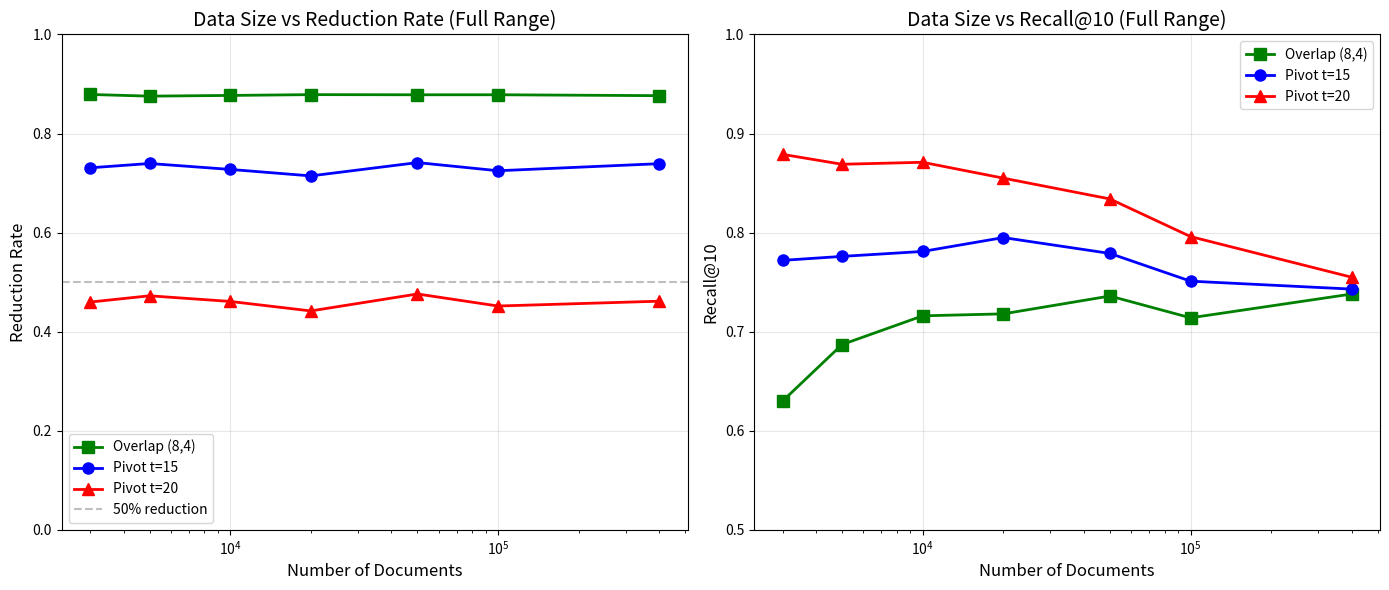

In [13]:
# 最終グラフ：全データ規模での推移
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

strategies_to_plot = ['Overlap (8,4)', 'Pivot t=15', 'Pivot t=20']

# 削減率
ax1 = axes[0]
for strategy in strategies_to_plot:
    df_strategy = df_combined[df_combined['name'] == strategy].sort_values('n_docs')
    ax1.plot(df_strategy['n_docs'], df_strategy['reduction_rate'], 
             marker=markers[strategy], color=colors[strategy], 
             label=strategy, linewidth=2, markersize=8)

ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='50% reduction')
ax1.set_xlabel('Number of Documents', fontsize=12)
ax1.set_ylabel('Reduction Rate', fontsize=12)
ax1.set_title('Data Size vs Reduction Rate (Full Range)', fontsize=14)
ax1.set_xscale('log')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_ylim(0, 1)

# Recall@10
ax2 = axes[1]
for strategy in strategies_to_plot:
    df_strategy = df_combined[df_combined['name'] == strategy].sort_values('n_docs')
    ax2.plot(df_strategy['n_docs'], df_strategy['recall@10'], 
             marker=markers[strategy], color=colors[strategy], 
             label=strategy, linewidth=2, markersize=8)

ax2.set_xlabel('Number of Documents', fontsize=12)
ax2.set_ylabel('Recall@10', fontsize=12)
ax2.set_title('Data Size vs Recall@10 (Full Range)', fontsize=14)
ax2.set_xscale('log')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_ylim(0.5, 1)

plt.tight_layout()
plt.savefig(DATA_DIR / '56_data_size_vs_performance_full.png', dpi=100, bbox_inches='tight')
plt.show()

---

## 8. 実験56 評価

## 評価結果

### 実験目的
小規模データ（5,000〜10,000件）でPivot戦略が有効かを検証し、実験55の結論の妥当性を確認する。

### 主要な発見

#### 1. 削減率はデータ規模に依存しない（公開データ）

| 戦略 | 3,000件 | 10,000件 | 100,000件 | 399,029件 |
|------|---------|----------|-----------|-----------|
| Overlap (8,4) | 87.9% | 87.7% | 87.8% | 87.7% |
| Pivot t=15 | 73.1% | 72.8% | 72.5% | 73.9% |
| Pivot t=20 | 46.0% | 46.1% | 45.2% | 46.2% |

→ **削減率は3,000件から40万件まで安定**（非公開データとは異なる結果）

#### 2. Recall@10はデータ規模増加で低下（特にPivot t=20）

| 戦略 | 3,000件 | 10,000件 | 100,000件 | 399,029件 | 変化幅 |
|------|---------|----------|-----------|-----------|--------|
| Overlap (8,4) | 63.0% | 71.6% | 71.4% | 73.8% | +10.8pt |
| Pivot t=15 | 77.2% | 78.1% | 75.1% | 74.3% | -2.9pt |
| Pivot t=20 | 87.9% | 87.1% | 79.6% | 75.5% | **-12.4pt** |

→ **Pivot t=20のRecallは小規模では高いが、大規模では低下する**

#### 3. Filter Recallはデータ規模増加で向上

| 戦略 | 3,000件 | 399,029件 |
|------|---------|-----------|
| Overlap (8,4) | 63.0% | 82.4% |
| Pivot t=15 | 77.3% | 85.9% |
| Pivot t=20 | 88.6% | 89.8% |

→ データ規模が大きいほど、フィルタリング後にTop-10が含まれやすくなる

### 考察

#### なぜ非公開データ（2,789件）では削減率が低かったのか？

非公開データ（ResOU）での観察:
- Overlap (8,4): 45-56%削減
- Pivot t=20: 3-5%削減

公開データ（Wikipedia 3,000件）:
- Overlap (8,4): 87.9%削減
- Pivot t=20: 46.0%削減

**原因の仮説**:
1. **データ分布の違い**: 非公開データは特定ドメインに特化しており、ハッシュ空間での分布が密集している可能性
2. **類似文書の割合**: 非公開データは類似文書が多く、ピボット距離やセグメント値が近い文書が多数存在
3. **128ビット空間での配置**: Wikipediaは多様なトピックをカバーするため、ハッシュ空間で広く分散

#### なぜRecall@10はデータ規模増加で低下するのか？

- 削減率が一定でも、**候補の絶対数は増加**（10,000件の46%削減 = 4,600件、400,000件の46%削減 = 184,000件）
- `candidate_limit=500` でハミング距離上位500件に絞るが、大規模データでは真のTop-10が500件外にはみ出す
- **ハミング距離とコサイン類似度の乖離**が大規模データで顕著になる

### 結論の修正

#### 実験55の結論は「公開データ（Wikipedia）に限定」して有効

| 項目 | 実験55の結論 | 修正後 |
|------|-------------|--------|
| Pivot t=20推奨 | ◎（削減率47%, Recall 89.8%） | △（大規模では有効、小規模ドメイン特化データでは要注意）|
| Overlap (8,4) | △（削減率高いがRecall低い） | ○（ドメイン特化データでは相対的に安定）|

#### データ特性に応じた戦略選択

| データ特性 | 推奨戦略 | 理由 |
|-----------|---------|------|
| 大規模・多様（40万件+、Wikipedia等） | Pivot t=15〜20 | 安定した削減率とRecall |
| 中規模・汎用（1万〜10万件） | Pivot t=15 | バランス良好 |
| 小規模・ドメイン特化（〜5,000件） | **要検証** | 削減率がデータ分布に強く依存 |

#### 最終推奨

1. **まず小規模サンプルで削減率を検証**してから本番適用
2. ドメイン特化データでは、Overlap戦略も検討価値あり
3. Pivot t=20は小規模データで高Recallだが、スケールアップ時にRecall低下リスクあり
4. **Pivot t=15が最もスケール耐性が高い**（削減率73%、Recall 74-78%で安定）

---

## 9. ピボットの汎化性と事前選定について

### 疑問: ピボットはデータ依存か？

ピボット戦略を実運用する場合、以下の懸念がある:
- データが増え続ける環境で、ピボットを都度再選定する必要があるか？
- 事前に固定のピボットを決めておくことは可能か？

### 結論: ピボットは事前に選定可能

**ピボットが依存するもの**:

| 要素 | 依存度 | 説明 |
|------|--------|------|
| 埋め込みモデル (E5-base) | **強** | モデルが変わればハッシュ空間の分布が変わる |
| ITQ回転行列 | **強** | 768次元→128ビットの変換を定義 |
| 実際のデータ | **弱** | ハッシュ空間での分布には影響するが、ピボット自体の有効性には影響小 |

### 理論的背景

ピボットは「128ビットハミング空間における参照点」として機能する:

```
128ビットハミング空間 = 2^128 個の離散点からなる空間
  ↓
E5-base + ITQ行列 が決まれば、どんなテキストも同じ空間にマッピング
  ↓
空間自体は固定なので、「よく分散した参照点」は普遍的に使える
```

### 実用的なアプローチ

```
【1回だけ実施（モデル・ITQ行列ごと）】
大規模・多様なデータ（Wikipedia 40万件等）でピボットを選定
  ↓
pivots_8_furthest_first.npy として保存
  ↓
【以降、どんなデータでも同じピボットを使用】
- 新規文書追加時: 8個のピボット距離を計算してDBに保存
- ピボットの再選定は不要
- しきい値(t)は運用中に調整可能（再インデックス不要）
```

### 実験56の結果が示す汎化性

本実験では、**Wikipedia 40万件から選定したピボット**を使用して、3,000件〜40万件の様々な規模で評価した:

| データ規模 | ピボット選定元 | 削減率 (t=15) | 結果 |
|-----------|--------------|---------------|------|
| 3,000件 | Wikipedia 40万件 | 73.1% | ✓ 機能 |
| 10,000件 | Wikipedia 40万件 | 72.8% | ✓ 機能 |
| 100,000件 | Wikipedia 40万件 | 72.5% | ✓ 機能 |
| 399,029件 | Wikipedia 40万件 | 73.9% | ✓ 機能 |

→ **同じピボットが異なるデータ規模で安定して機能**

### 注意点

1. **埋め込みモデルを変更した場合**: ピボットの再選定が必要
2. **ITQ行列を再学習した場合**: ピボットの再選定が必要
3. **ドメイン特化データ**: ピボット自体は有効だが、削減率がデータ分布に依存（本実験の非公開データでの結果参照）

### 実装時のまとめ

| 項目 | 実装方針 |
|------|---------|
| ピボット選定 | E5-base + 128bit ITQ に対して1回だけ実施 |
| ピボット保存 | `pivots_8_furthest_first.npy` を共通で使用 |
| 新規文書追加 | 8個のピボット距離を計算してDBに保存 |
| しきい値調整 | クエリ時パラメータ（再インデックス不要） |
| モデル変更時 | ITQ行列とピボットの両方を再選定 |

**現在のファイル `data/pivots_8_furthest_first.npy` は、E5-base + 128bit ITQ を使用する限り、汎用的に利用可能。**